<a href="https://colab.research.google.com/github/hargurjeet/DeepLearning/blob/main/Fake_News_Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Upload kaggle.jason
# please follow this link incase not aware: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset'
od.download(dataset_url)

Saving kaggle.json to kaggle.json


  0%|          | 0.00/41.0M [00:00<?, ?B/s]

100%|██████████| 41.0M/41.0M [00:00<00:00, 43.0MB/s]


In [3]:
real_news = pd.read_csv('/content/fake-and-real-news-dataset/True.csv')
fake_news = pd.read_csv('/content/fake-and-real-news-dataset/Fake.csv')
real_news.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_news.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
print(real_news.shape)
print(fake_news.shape)

(21417, 4)
(23481, 4)


In [6]:
real_news['FakeOrNot'] = 1
fake_news['FakeOrNot'] = 0

In [7]:
News_Dataset = pd.concat([real_news, fake_news], ignore_index=True)
News_Dataset.head()

,title,text,subject,date,FakeOrNot
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
News_Dataset.shape

(44898, 5)

In [9]:
News_Dataset.columns

Index(['title', 'text', 'subject', 'date', 'FakeOrNot'], dtype='object')

In [10]:
News_Dataset = News_Dataset.drop(['text', 'subject', 'date'], axis = 1)
News_Dataset

,title,FakeOrNot
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [11]:
News_Dataset.FakeOrNot.value_counts()

0    23481
1    21417
Name: FakeOrNot, dtype: int64

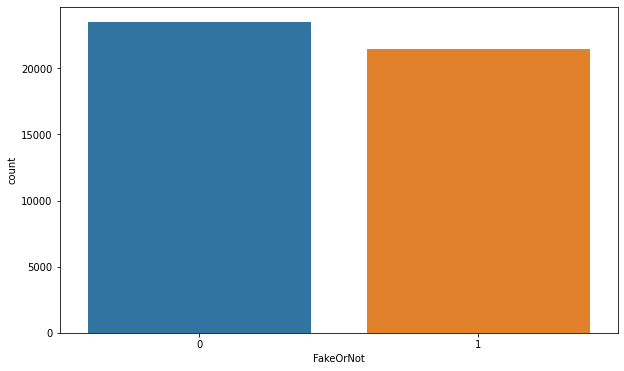

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data = News_Dataset, x='FakeOrNot')
plt.show()

In [13]:
News_Dataset[News_Dataset.isnull().any(axis=1)]

,title,FakeOrNot


In [14]:
News_Dataset.title.replace("[^a-zA-Z]"," ",regex=True, inplace=True)

In [15]:
News_Dataset

,title,FakeOrNot
0,As U S budget fight looms Republicans flip t...,1
1,U S military to accept transgender recruits o...,1
2,Senior U S Republican senator Let Mr Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge much mor...,1
...,...,...
44893,McPain John McCain Furious That Iran Treated ...,0
44894,JUSTICE Yahoo Settles E mail Privacy Class ac...,0
44895,Sunnistan US and Allied Safe Zone Plan to T...,0
44896,How to Blow Million Al Jazeera America F...,0


In [16]:
pd.set_option('display.max_colwidth', None)
News_Dataset.title = News_Dataset.title.str.lower()

In [17]:
News_Dataset[:10]

,title,FakeOrNot
0,as u s budget fight looms republicans flip their fiscal script,1
1,u s military to accept transgender recruits on monday pentagon,1
2,senior u s republican senator let mr mueller do his job,1
3,fbi russia probe helped by australian diplomat tip off nyt,1
4,trump wants postal service to charge much more for amazon shipments,1
5,white house congress prepare for talks on spending immigration,1
6,trump says russia probe will be fair but timeline unclear nyt,1
7,factbox trump on twitter dec approval rating amazon,1
8,trump on twitter dec global warming,1
9,alabama official to certify senator elect jones today despite challenge cnn,1


In [18]:
# ps = PorterStemmer()
# corpus = []
# for i in range(0, len(News_Dataset)):
#     review = re.sub('[^a-zA-Z]', ' ', News_Dataset['title'][i])
#     review = review.lower()
#     review = review.split()
    
#     review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
#     review = ' '.join(review)
#     corpus.append(review)

In [19]:
# corpus[3]

In [20]:
nltk.download('wordnet')
wordnet=WordNetLemmatizer()
corpus = []

for i in range(0, len(News_Dataset)):
    review = re.sub('[^a-zA-Z]', ' ', News_Dataset['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [wordnet.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [21]:
## Applying Countvectorizer
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [22]:
X.shape

(44898, 5000)

In [23]:
y=News_Dataset['FakeOrNot']

In [24]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [25]:
cv.get_feature_names()[:20]

['abadi',
 'abandon',
 'abbas',
 'abc',
 'abc news',
 'abe',
 'abedin',
 'able',
 'abortion',
 'abroad',
 'absolute',
 'absolutely',
 'abuse',
 'academic',
 'accept',
 'accepts',
 'access',
 'accident',
 'accidentally',
 'accord']

In [26]:
cv.get_feature_names()[:20]

['abadi',
 'abandon',
 'abbas',
 'abc',
 'abc news',
 'abe',
 'abedin',
 'able',
 'abortion',
 'abroad',
 'absolute',
 'absolutely',
 'abuse',
 'academic',
 'accept',
 'accepts',
 'access',
 'accident',
 'accidentally',
 'accord']

In [27]:
count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())

In [28]:

count_df.head()

,abadi,abandon,abbas,abc,abc news,abe,abedin,able,abortion,abroad,absolute,absolutely,abuse,academic,accept,accepts,access,accident,accidentally,accord,account,accusation,accuse,accused,accuser,accuses,across,across america,act,acting,action,active,activist,activity,actor,actress,actual,actually,ad,ad video,...,wrote,wsj,wwii,xi,xi say,xinhua,yahoo,yates,year,year ago,year jail,year old,year old girl,year video,yell,yemen,yemeni,yes,yet,yet another,yikes,york,york city,york time,young,youth,youtube,yr,yr old,yr old girl,zealand,zero,zika,zika funding,zimbabwe,zimbabwe mugabe,zone,zor,zuckerberg,zuma
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
import matplotlib.pyplot as plt

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

In [32]:
from sklearn import metrics
import numpy as np
import itertools

accuracy:   0.931
Confusion matrix, without normalization


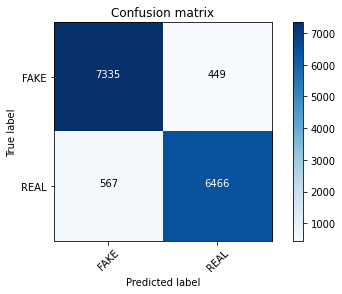

In [33]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [34]:

classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.9314301140581764

In [35]:
y_train.shape

(30081,)

Multinomial Classifier with Hyperparameter

In [36]:

classifier=MultinomialNB(alpha=0.1)


previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.0, Score : 0.9308227036512114
Alpha: 0.1, Score : 0.9325099547816698
Alpha: 0.2, Score : 0.9326449348721063
Alpha: 0.30000000000000004, Score : 0.9321050145103598
Alpha: 0.4, Score : 0.9319025443747048
Alpha: 0.5, Score : 0.9318350543294864
Alpha: 0.6000000000000001, Score : 0.9317675642842681
Alpha: 0.7000000000000001, Score : 0.9314301140581764
Alpha: 0.8, Score : 0.9313626240129581
Alpha: 0.9, Score : 0.9315650941486131


In [37]:
## Get Features names
feature_names = cv.get_feature_names()

In [38]:
classifier.coef_[0]

array([ -9.05244047,  -9.61746655,  -9.05244047, ...,  -8.39220302,
       -10.61961857,  -8.2217233 ])

In [39]:

### Most real
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[:20]

[(-3.4615340216631516, 'trump'),
 (-3.9822701549770576, 'say'),
 (-4.810234228989376, 'house'),
 (-5.198320968179188, 'russia'),
 (-5.219896778161146, 'republican'),
 (-5.235598152699469, 'north'),
 (-5.279266151366009, 'korea'),
 (-5.302682508127249, 'new'),
 (-5.324928463155145, 'state'),
 (-5.376413030923034, 'white'),
 (-5.402249492941674, 'white house'),
 (-5.421121538220624, 'senate'),
 (-5.428771221727732, 'china'),
 (-5.444248412083655, 'court'),
 (-5.496270543290223, 'north korea'),
 (-5.553320231932999, 'bill'),
 (-5.584234594845447, 'election'),
 (-5.586479768666882, 'obama'),
 (-5.600057709784689, 'vote'),
 (-5.606916447234531, 'clinton')]

In [40]:
### Most fake
sorted(zip(classifier.coef_[0], feature_names))[:20]

[(-11.789689822136705, 'accidentally'),
 (-11.789689822136705, 'across america'),
 (-11.789689822136705, 'actor'),
 (-11.789689822136705, 'actual'),
 (-11.789689822136705, 'actually'),
 (-11.789689822136705, 'ad video'),
 (-11.789689822136705, 'agitator'),
 (-11.789689822136705, 'akbar'),
 (-11.789689822136705, 'al sharpton'),
 (-11.789689822136705, 'alan'),
 (-11.789689822136705, 'alien'),
 (-11.789689822136705, 'allen'),
 (-11.789689822136705, 'amazing'),
 (-11.789689822136705, 'america great'),
 (-11.789689822136705, 'america video'),
 (-11.789689822136705, 'american flag'),
 (-11.789689822136705, 'anarchist'),
 (-11.789689822136705, 'anderson cooper'),
 (-11.789689822136705, 'andrea'),
 (-11.789689822136705, 'angela')]

Implementing TFIDF

In [41]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X = cv.fit_transform(corpus).toarray()

In [42]:

X.shape

(44898, 17622)

In [43]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [44]:
cv.get_feature_names()[:20]

['aa',
 'aar',
 'aardvark',
 'aaron',
 'aarp',
 'abadi',
 'abandon',
 'abandoned',
 'abandoning',
 'abbas',
 'abbott',
 'abc',
 'abdeslam',
 'abdicate',
 'abdication',
 'abdo',
 'abduct',
 'abducted',
 'abduction',
 'abdul']

In [45]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [46]:
count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())

count_df.head()

,aa,aar,aardvark,aaron,aarp,abadi,abandon,abandoned,abandoning,abbas,abbott,abc,abdeslam,abdicate,abdication,abdo,abduct,abducted,abduction,abdul,abdullah,abe,abed,abedin,abercrombie,aberdeen,abertis,abetted,abhorrent,abide,abiding,ability,abject,able,abnormality,aboard,abolish,abolished,abolishes,abolition,...,zarif,zarrab,zbc,zbigniew,zealand,zealot,zeid,zeldin,zellweger,zelnicek,zephyr,zero,zhong,zika,zilch,zimbabwe,zimbabwean,zimmerman,zing,zinger,zinke,zionist,ziraat,zit,zoellick,zohra,zombie,zombiehillary,zone,zoning,zoo,zoolander,zor,zschaepe,zucker,zuckerberg,zulia,zuma,zummar,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


accuracy:   0.933
Confusion matrix, without normalization


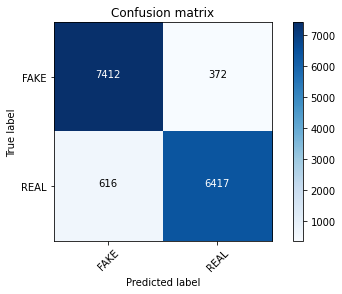

In [47]:

from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [48]:

classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.9333198353242896

accuracy:   0.935
Confusion matrix, without normalization


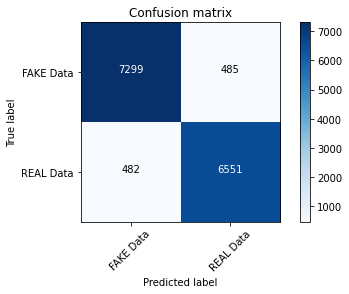

In [49]:
# Passive Aggressive Classifier Algorithm
from sklearn.linear_model import PassiveAggressiveClassifier

linear_clf = PassiveAggressiveClassifier(n_iter_no_change=50)

linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])


Multinomial Classifier with Hyperparameter

In [50]:
classifier=MultinomialNB(alpha=0.1)

previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.0, Score : 0.9128028615779172
Alpha: 0.1, Score : 0.932577444826888
Alpha: 0.2, Score : 0.935007086454748
Alpha: 0.30000000000000004, Score : 0.9353445366808396
Alpha: 0.4, Score : 0.9353445366808396
Alpha: 0.5, Score : 0.9349395964095296
Alpha: 0.6000000000000001, Score : 0.9344671660930013
Alpha: 0.7000000000000001, Score : 0.934602146183438
Alpha: 0.8, Score : 0.933792265640818
Alpha: 0.9, Score : 0.9332523452790713


In [51]:
#credit card transcation
2530+653+2070+5000+530+250+1163+1053+3948+282+320+271+1320

19390

In [52]:
#phone pay transcation
964+100+63+615+122+2709+187+140+280+945(milk)

NameError: ignored

In [ ]:
total
19390+6125

In [ ]:
83+1224+25515